In [426]:
# AWS
import boto3
import sagemaker

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn')
import seaborn as sns

# data analysis
import pandas as pd
import numpy as np

import os
import pickle

In [427]:
# Sagemaker activation
session = boto3.session.Session()
region_name = session.region_name
print(f'region name: {region_name}')
sagemaker_session = sagemaker.Session()
bucket = 'klarnadataset'
role = sagemaker.get_execution_role()

region name: us-east-2


In [428]:
# load data from S3 bucket
data_key = 'dataset.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location,delimiter=';')
df.head(5)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [429]:
# save model in S3
def upload_to_S3(pkl_filename,model):
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    s3_resource = boto3.resource('s3')
    pickle_byte_obj = pickle.dumps(model)
    s3_resource.Object(bucket,pkl_filename).put(Body=pickle_byte_obj)

## Missing values imputation

In [430]:
pd.DataFrame(df.isnull().sum(),columns=['number of nan'])

,number of nan
uuid,0
default,10000
account_amount_added_12_24m,0
account_days_in_dc_12_24m,11836
account_days_in_rem_12_24m,11836
account_days_in_term_12_24m,11836
account_incoming_debt_vs_paid_0_24m,59315
account_status,54373
account_worst_status_0_3m,54373
account_worst_status_12_24m,66761


## Drop columns

#### As analyzed in notebook (0), filling-in the nan for some of the variables would introduce more bias than the actual benefit of imputing new values. Therefore, they are dropped off.

In [431]:
df.drop(columns=['num_arch_written_off_0_12m',
                 'num_arch_written_off_12_24m',
                 'account_incoming_debt_vs_paid_0_24m',
                 'merchant_category'],inplace=True)

## Split train and test set to avoid data leakeage during nan imputation

In [432]:
df_train = df[df['default'].notnull()]
X_train,y_train = df_train.drop('default', axis=1),df_train['default']
print(f'train set rows: {df_train.shape[0]}')

df_test = df[df['default'].isnull()]
X_test,y_test = df_test.drop('default', axis=1),df_test['default']
print(f'test set rows: {df_test.shape[0]}')


train set rows: 89976
test set rows: 10000


In [433]:
datasets = [df,X_train,X_test]

# nan imputation

## 0) account_days_in_dc_12_24m & account_days_in_rem_12_24m & account_days_in_term_12_24m

In [434]:
print('missing values')
pd.DataFrame(df[['account_days_in_dc_12_24m',
                 'account_days_in_rem_12_24m',
                 'account_days_in_term_12_24m']].isnull().sum(), columns=['missing values'])

missing values


,missing values
account_days_in_dc_12_24m,11836
account_days_in_rem_12_24m,11836
account_days_in_term_12_24m,11836


In [435]:
for feature in ['account_days_in_term_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m']:
    print(f'Percentage of zeros in {feature}: {round((df[feature].value_counts() / df[feature].count() ) * 100,2)[0]} %')

Percentage of zeros in account_days_in_term_12_24m: 98.63 %
Percentage of zeros in account_days_in_dc_12_24m: 99.7 %
Percentage of zeros in account_days_in_rem_12_24m: 89.09 %


#### Strategy for "account_days_in_term_12_24m" & "account_days_in_dc_12_24m":
#### Fill nan with the most frequent observation (zero):

In [436]:
for dataset in datasets:
    dataset['account_days_in_dc_12_24m'].fillna(value=0,inplace=True)
    dataset['account_days_in_term_12_24m'].fillna(value=0,inplace=True)

#### account_days_in_rem_12_24m

In [437]:
# account_worst_status_12_24m & account_worst_status_12_24m without nan
no_nan = df.loc[df.loc[df['account_worst_status_12_24m'].dropna().index]['account_days_in_rem_12_24m'].dropna().index]

account_worst_status = 1 (the majority) have 0 account_days_in_rem. The worst_status increases with account_days_in_rem. We will use that to fill missing values.


<AxesSubplot:xlabel='account_worst_status_12_24m', ylabel='account_days_in_rem_12_24m'>

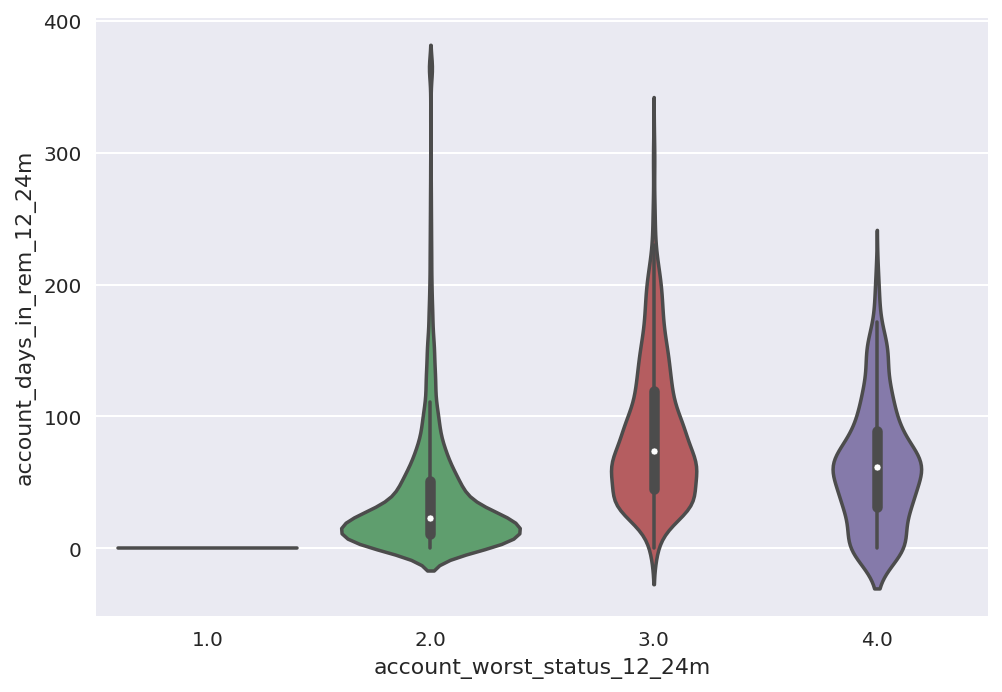

In [438]:
print('account_worst_status = 1 (the majority) have 0 account_days_in_rem. The worst_status increases with account_days_in_rem. We will use that to fill missing values.')
sns.violinplot(x='account_worst_status_12_24m',y='account_days_in_rem_12_24m',data=no_nan)

In [439]:
# We extract the median for each group plotted above
medians = []
for account_worst_status in X_train['account_worst_status_12_24m'].dropna().unique():
    medians.append(X_train[X_train['account_worst_status_12_24m'] == account_worst_status]['account_days_in_rem_12_24m'].median())
medians

[0.0, 23.0, 73.0, 62.0]

In [440]:
def inputer_account_days_in_rem_12_24m(x,medians): # imputing using its correlation with account_worst_status_12_24m
    a = 0
    if pd.isnull(x['account_days_in_rem_12_24m']):
        if x['account_worst_status_12_24m'] == 1:
            a = medians[0]
        elif x['account_worst_status_12_24m'] == 2:
            a = medians[1]
        elif x['account_worst_status_12_24m'] in [3,4]:
            a = (medians[2] + medians[3]) / 2
    else:
        a = x['account_days_in_rem_12_24m']
    return a

In [441]:
for dataset in datasets:
    dataset['account_days_in_rem_12_24m'] = dataset.apply(lambda x: inputer_account_days_in_rem_12_24m(x,medians),axis=1)

## 1) avg_payment_span_0_12m & avg_payment_span_0_3m

In [442]:
pd.DataFrame(df[["avg_payment_span_0_12m", "avg_payment_span_0_3m"]].isnull().sum(),columns=['missing values'])

,missing values
avg_payment_span_0_12m,23836
avg_payment_span_0_3m,49305


In [443]:
print('highly correlated variables:')
df.loc[df['avg_payment_span_0_12m'].dropna().index].corr()['avg_payment_span_0_12m'].sort_values(ascending=False).head(8)

highly correlated variables:


avg_payment_span_0_12m             1.000000
avg_payment_span_0_3m              0.741739
status_last_archived_0_24m         0.669296
status_max_archived_0_12_months    0.658633
status_max_archived_0_24_months    0.582940
num_arch_dc_0_12m                  0.453490
status_2nd_last_archived_0_24m     0.389179
num_arch_rem_0_12m                 0.340123
Name: avg_payment_span_0_12m, dtype: float64

#### Since there are many highly correlated variables. A simple linear regression model is used to fill in the nan of avg_payment_span_0_12m

In [444]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [445]:
avg_payment_12_without_nan = X_train.loc[X_train['avg_payment_span_0_12m'].dropna().index][['avg_payment_span_0_12m',
                                                     'status_last_archived_0_24m',
                                                     'status_max_archived_0_12_months',               
                                                     'status_max_archived_0_24_months',
                                                     'num_arch_rem_0_12m']]

In [446]:
print('since the distributions and range of the independent variables are similar we skip the normalization') 
avg_payment_12_without_nan.describe() 

since the distributions and range of the independent variables are similar we skip the normalization


,avg_payment_span_0_12m,status_last_archived_0_24m,status_max_archived_0_12_months,status_max_archived_0_24_months,num_arch_rem_0_12m
count,68508.000000,68508.000000,68508.000000,68508.000000,68508.000000
mean,17.977933,1.123825,1.379853,1.515356,0.613607
std,12.804216,0.383826,0.597850,0.658419,1.519396
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.800000,1.000000,1.000000,1.000000,0.000000
50%,14.904762,1.000000,1.000000,1.000000,0.000000
75%,21.040124,1.000000,2.000000,2.000000,1.000000
max,260.000000,5.000000,5.000000,5.000000,42.000000


In [447]:
# train / val split
X_train_span_0_12m, X_val_span_0_12m, y_train_span_0_12m, y_val_span_0_12m = train_test_split(avg_payment_12_without_nan[[
                                                                                                         'status_last_archived_0_24m',
                                                                                                         'status_max_archived_0_12_months',
                                                                                                         'status_max_archived_0_24_months',
                                                                                                         'num_arch_rem_0_12m']],
                                                                                                avg_payment_12_without_nan['avg_payment_span_0_12m'], 
                                                                                                test_size=0.2, 
                                                                                                random_state=42)

In [448]:
lr_avg_payment = LinearRegression()

In [449]:
# Train the linear regression
lr_avg_payment.fit(X_train_span_0_12m,y_train_span_0_12m)

LinearRegression()

In [450]:
# save model in S3
pkl_filename = 'lr_avg_payment.pkl'
upload_to_S3(pkl_filename,lr_avg_payment)

In [451]:
train_error_mae = mean_absolute_error(y_train_span_0_12m,lr_avg_payment.predict(X_train_span_0_12m))
test_error_mae = mean_absolute_error(y_val_span_0_12m,lr_avg_payment.predict(X_val_span_0_12m))
print(f'mae train error = {train_error_mae}, mae test error = {test_error_mae}')

mae train error = 5.573087769333173, mae test error = 5.573871674631771


In [452]:
def inputer_avg_payment_span_0_12m(x):   # imputing values using the linear model fitted on the training set
    a = 0
    if pd.isnull(x['avg_payment_span_0_12m']):
        a = lr_avg_payment.predict(np.array(x[['status_last_archived_0_24m',
                            'status_max_archived_0_12_months',
                            'status_max_archived_0_24_months',
                            'num_arch_rem_0_12m']]).reshape(1,4))[0]
        a = np.clip(a,0,None)
    else:
        a = x['avg_payment_span_0_12m']
    return a

In [453]:
for dataset in datasets:
    dataset['avg_payment_span_0_12m'] = dataset.apply(lambda x: inputer_avg_payment_span_0_12m(x),axis=1)

There is a linear relationship between 'avg_payment_span_0_12m' & 'avg_payment_span_0_3m' with a mean absolute error of 4.21 and it intercepts around zero. As seen from the plot below, the slope of the linear fitting is about 120/100. The missing values in 'avg_payment_span_0_3m', are filled up using this correlation


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='avg_payment_span_0_12m', ylabel='avg_payment_span_0_3m'>

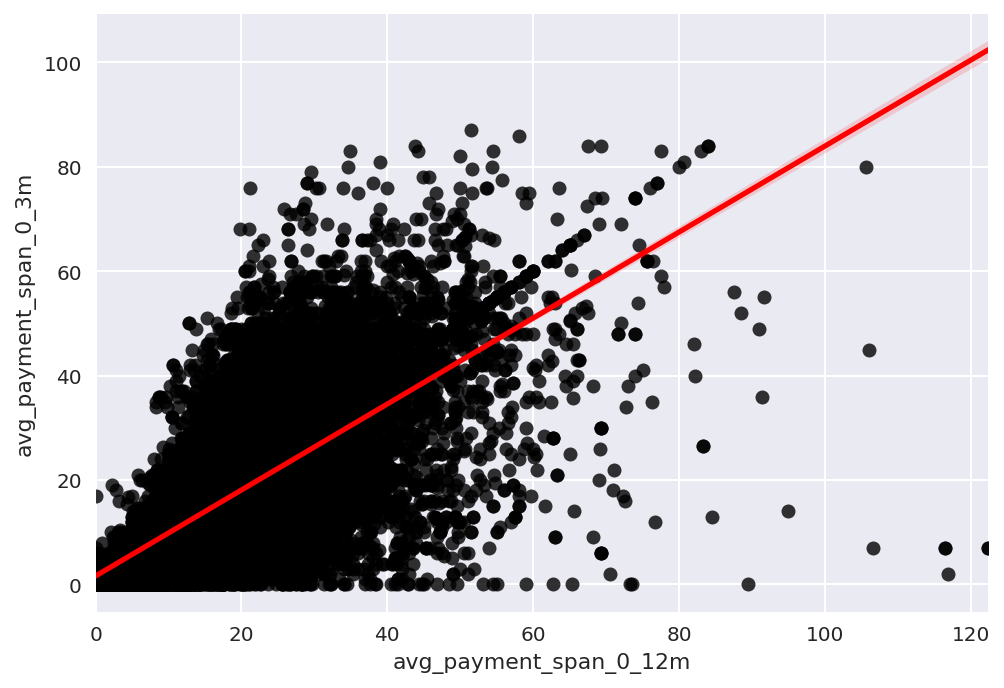

In [454]:
avg_payment_without_nan = df[['avg_payment_span_0_12m','avg_payment_span_0_3m']].dropna()
mae = mean_absolute_error(avg_payment_without_nan['avg_payment_span_0_12m'],avg_payment_without_nan
                    ['avg_payment_span_0_3m'])

print(f"There is a linear relationship between 'avg_payment_span_0_12m' & 'avg_payment_span_0_3m' with a mean absolute error of {round(mae,2)} and it intercepts around zero. As seen from the plot below, the slope of the linear fitting is about 120/100. The missing values in 'avg_payment_span_0_3m', are filled up using this correlation")
sns.regplot('avg_payment_span_0_12m','avg_payment_span_0_3m',df,scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [455]:
slope = 120/100

In [456]:
for dataset in datasets:
    dataset['avg_payment_span_0_3m'] = dataset.apply(lambda x: (slope * x['avg_payment_span_0_12m']) if pd.isnull(x['avg_payment_span_0_3m']) 
         else x['avg_payment_span_0_3m'],axis=1)

## 2) worst status active inv

In [457]:
missing_values = df['worst_status_active_inv'].isnull().sum()
print(f'missing values= {missing_values}')

missing values= 69515


In [458]:
df['worst_status_active_inv'].dropna().value_counts()

1.0    26922
2.0     3369
3.0      170
Name: worst_status_active_inv, dtype: int64

In [459]:
print('As seen in the visualization notebook. Some features correlate linearly with worst_status_active_inv')
worst_status_active_inv_without_nan = df.loc[df['worst_status_active_inv'].dropna().index]
worst_status_active_inv_without_nan.corr()['worst_status_active_inv'].sort_values(ascending=False).head(5)

As seen in the visualization notebook. Some features correlate linearly with worst_status_active_inv


worst_status_active_inv    1.000000
recovery_debt              0.291179
avg_payment_span_0_12m     0.248673
avg_payment_span_0_3m      0.243617
num_arch_rem_0_12m         0.241682
Name: worst_status_active_inv, dtype: float64

In [460]:
X_train_without_worst_status_nan = X_train.loc[X_train['worst_status_active_inv'].dropna().index]
X_train_without_worst_status_nan[['recovery_debt',
                                  'avg_payment_span_0_12m',
                                  'avg_payment_span_0_3m',
                                  'num_arch_rem_0_12m',
                                  'worst_status_active_inv']].head(3)

,recovery_debt,avg_payment_span_0_12m,avg_payment_span_0_3m,num_arch_rem_0_12m,worst_status_active_inv
0,0,12.692308,8.333333,0,1.0
2,0,20.000000,18.000000,3,1.0
3,0,4.687500,4.888889,0,1.0


In [461]:
# train / val split
X_train_worst_status, X_val_worst_status, y_train_worst_status, y_val_worst_status = train_test_split(X_train_without_worst_status_nan[[
                                                                                                            'recovery_debt', 
                                                                                                            'avg_payment_span_0_12m',
                                                                                                            'avg_payment_span_0_3m',
                                                                                                            'num_arch_rem_0_12m']],
                                                                                                X_train_without_worst_status_nan['worst_status_active_inv'], 
                                                                                                test_size=0.2, 
                                                                                                random_state=42)

In [462]:
from sklearn.preprocessing import MinMaxScaler

In [463]:
scaler = MinMaxScaler()

In [464]:
# data normalization
X_train_worst_status = scaler.fit_transform(X_train_worst_status)
X_val_worst_status = scaler.transform(X_val_worst_status)

# save scaler in S3
pkl_filename = 'scaler_worst_status_active_inv.pkl'
upload_to_S3(pkl_filename,scaler)

In [465]:
lr_worst_status = LinearRegression()

In [466]:
lr_worst_status.fit(X_train_worst_status,y_train_worst_status)

LinearRegression()

In [467]:
# save scaler in S3
pkl_filename = 'lr_worst_status_active_inv.pkl'
upload_to_S3(pkl_filename,lr_worst_status)

In [468]:
train_error_mae = mean_absolute_error(y_train_worst_status,
                                      lr_worst_status.predict(X_train_worst_status))

test_error_mae = mean_absolute_error(y_val_worst_status,
                                     lr_worst_status.predict(X_val_worst_status))

print(f'train error = {train_error_mae}, test error = {test_error_mae}')

train error = 0.18822180420572562, test error = 0.19067355856069612


In [469]:
def inputer_worst_status_active_inv(x):
    a = 0
    if pd.isnull(x['worst_status_active_inv']):
        X_data = scaler.transform(np.array(x[['recovery_debt', 
                                     'avg_payment_span_0_12m',
                                     'avg_payment_span_0_3m',
                                     'num_arch_rem_0_12m']]).reshape(1,4))
        a = lr_worst_status.predict(X_data)[0]
        a = np.clip(a,1.,3.)
    else:
        a = x['worst_status_active_inv']
    return a

In [470]:
for dataset in datasets:
    dataset['worst_status_active_inv'] = dataset.apply(lambda x: inputer_worst_status_active_inv(x),axis=1)

## 3) num_active_div_by_paid_inv_0_12m

#### KNN strategy to fill in nan

In [471]:
# Do not include categorical columns (not prepared yet), index, and account columns (with many nan), and target (default)
column_predictors = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
       'age', 'avg_payment_span_0_12m','avg_payment_span_0_3m', 
       'has_paid', 'max_paid_inv_0_12m', 
       'max_paid_inv_0_24m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 
       'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 
       'num_arch_rem_0_12m', 'num_unpaid_bills',
       'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_12_months', 'status_max_archived_0_24_months',
       'recovery_debt', 'sum_capital_paid_account_0_12m',
       'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 
        'time_hours', 'worst_status_active_inv']

In [472]:
def data_preprocessing_knn(df,feature_name,column_predictors):
    feature_without_nan = df.loc[df[feature_name].dropna().index]
    feature_without_nan = feature_without_nan.dropna()
    X_feature = feature_without_nan[column_predictors]
    y_feature = feature_without_nan[feature_name]


    X_train_, X_validate_, X_test_ = np.split(X_feature.sample(frac=1, random_state=42), 
                       [int(.6*len(X_feature)), int(.8*len(X_feature))])


    y_train_, y_validate_, y_test_ = np.split(y_feature.sample(frac=1, random_state=42), 
                       [int(.6*len(y_feature)), int(.8*len(y_feature))])
    
    scaler_ = MinMaxScaler()
    X_train_norm = scaler_.fit_transform(X_train_)
    X_validate_norm = scaler_.transform(X_validate_)
    X_test_norm = scaler_.transform(X_test_)
    
    return X_train_norm, X_validate_norm, X_test_norm,y_train_, y_validate_, y_test_,scaler_

In [473]:
X_train_div_by_paid_norm, X_val_div_by_paid_norm, X_test_div_by_paid_norm, y_train_div_by_paid, y_validate_div_by_paid, y_test_div_by_paid, scaler = data_preprocessing_knn(X_train,'num_active_div_by_paid_inv_0_12m',column_predictors)

In [474]:
# save scaler in S3
pkl_filename = 'num_active_dim_scaler.pkl'

upload_to_S3(pkl_filename,scaler)

In [475]:
from sklearn.neighbors import KNeighborsRegressor

In [476]:
mae_knn_train = {}
mae_knn_val = {}
for number_of_neighbors in [3,5,8,10,15,20,25]:
    print(number_of_neighbors)
    knn_div_by_paid = KNeighborsRegressor(number_of_neighbors)
    knn_div_by_paid.fit(X_train_div_by_paid_norm,y_train_div_by_paid)
    
    mae_knn_train[number_of_neighbors] = mean_absolute_error(y_train_div_by_paid,
                                                             knn_div_by_paid.predict(X_train_div_by_paid_norm))
    
    mae_knn_val[number_of_neighbors] = mean_absolute_error(y_validate_div_by_paid,
                                                           knn_div_by_paid.predict(X_val_div_by_paid_norm))

3
5
8
10
15
20
25


In [477]:
mae_knn_df = pd.DataFrame.from_dict(mae_knn_train,orient='index',columns=['train_mae'])
mae_knn_df['val_mae'] = mae_knn_val.values()
mae_knn_df.index.name = 'neighbors'
mae_knn_df

,train_mae,val_mae
neighbors,,
3,0.085871,0.123161
5,0.101848,0.125329
8,0.113682,0.127268
10,0.118058,0.129111
15,0.124689,0.132006
20,0.128638,0.134577
25,0.131788,0.136396


In [478]:
knn_div_by_paid = KNeighborsRegressor(3)
knn_div_by_paid.fit(X_train_div_by_paid_norm,y_train_div_by_paid)
print(f"test mae: {mean_absolute_error(y_test_div_by_paid,knn_div_by_paid.predict(X_test_div_by_paid_norm))}")

test mae: 0.12256984832520826


In [479]:
# save model in S3
pkl_filename = 'knn_div_by_paid.pkl'
upload_to_S3(pkl_filename,knn_div_by_paid)

In [480]:
def inputer_num_active_div_by_paid_inv_0_12m(x):
    a = 0
    if pd.isnull(x['num_active_div_by_paid_inv_0_12m']):   
        X_data_normalized = scaler.transform(np.array(x[column_predictors]).reshape(1,len(column_predictors)))
        a = knn_div_by_paid.predict(X_data_normalized)[0]
        a = np.clip(a,0.,None)
    else:
        a = x['num_active_div_by_paid_inv_0_12m']
    return a

In [481]:
for dataset in datasets:
    dataset['num_active_div_by_paid_inv_0_12m'] = dataset.apply(lambda x: inputer_num_active_div_by_paid_inv_0_12m(x),axis=1)

## 4) Account_status

#### KNN strategy

In [501]:
# Do not include categorical columns (not prepared yet), index, and target (default)
column_predictors_account_status = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',                     
       'age', 'avg_payment_span_0_12m','avg_payment_span_0_3m', 
       'has_paid', 'max_paid_inv_0_12m', 
       'max_paid_inv_0_24m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 
       'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 
       'num_arch_rem_0_12m', 'num_unpaid_bills',
       'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_12_months', 'status_max_archived_0_24_months',
       'recovery_debt', 'sum_capital_paid_account_0_12m',
       'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 
        'time_hours', 'worst_status_active_inv','num_active_div_by_paid_inv_0_12m']

In [502]:
# split data and normalize it
feature_name = 'account_status'
X_train_account_norm, X_validate_account_norm, X_test_account_norm,y_train_account, y_validate_account, y_test_account, scaler = data_preprocessing_knn(X_train,feature_name,column_predictors_account_status)

In [503]:
# save scaler in S3
pkl_filename = 'account_scaler.pkl'
upload_to_S3(pkl_filename,scaler)

In [504]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [486]:
mae_knn_train = {}
mae_knn_val = {}
for number_of_neighbors in [3,5,8,10,15,20]:
    print(number_of_neighbors)
    knn_account = KNeighborsClassifier(number_of_neighbors)
    knn_account.fit(X_train_account_norm,y_train_account)
    mae_knn_train[number_of_neighbors] = accuracy_score(y_train_account,knn_account.predict(X_train_account_norm))
    mae_knn_val[number_of_neighbors] = accuracy_score(y_validate_account,knn_account.predict(X_validate_account_norm))

3
5
8
10
15
20


In [487]:
mae_knn_df = pd.DataFrame.from_dict(mae_knn_train,orient='index',columns=['train_acc'])
mae_knn_df['val_acc'] = mae_knn_val.values()
mae_knn_df.index.name = 'neighbors'
mae_knn_df

,train_acc,val_acc
neighbors,,
3,0.964015,0.954713
5,0.959782,0.959057
8,0.958278,0.960227
10,0.958111,0.960227
15,0.957943,0.960227
20,0.957665,0.959726


In [505]:
def inputer_account_status(x, feature,scaler_account):
    a = 0
    if pd.isnull(x[feature]):   
        X_data_normalized = scaler_account.transform(np.array(x[column_predictors_account_status]).reshape(1,len(column_predictors_account_status)))
        a = knn_account.predict(X_data_normalized)[0]
    else:
        a = x[feature]
    assert a != 0, 'problem with inputer_account_status'
    return a

In [506]:
feature_name = 'account_status'
knn_account = KNeighborsClassifier(8)
knn_account.fit(X_train_account_norm,y_train_account)
X_train_account_norm, X_validate_account_norm, X_test_account_norm,y_train_account, y_validate_account, y_test_account, scaler = data_preprocessing_knn(X_train,feature_name,column_predictors_account_status)

In [507]:
pkl_filename = 'account_status_knn.pkl'
upload_to_S3(pkl_filename,knn_account)

In [491]:
for dataset in datasets:
    dataset[feature_name] = dataset.apply(lambda x: inputer_account_status(x, feature_name,scaler),axis=1)

## 5) Worst_status new feature

In [508]:
#Select the worst historical account status
for dataset in datasets:
    dataset['worst_status'] = pd.DataFrame(dataset[['account_status','account_worst_status_0_3m',
                                'account_worst_status_12_24m',
                                'account_worst_status_3_6m',
                                'account_worst_status_6_12m']].max(axis=1))
    dataset.drop(columns=['account_worst_status_0_3m',
                                'account_worst_status_12_24m',
                                'account_worst_status_3_6m',
                                'account_worst_status_6_12m'],inplace=True)

KeyError: "['account_worst_status_6_12m', 'account_worst_status_12_24m', 'account_worst_status_0_3m', 'account_worst_status_3_6m'] not in index"

In [500]:
column_predictors_worst_status = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',                     
       'age', 'avg_payment_span_0_12m','avg_payment_span_0_3m', 
       'has_paid', 'max_paid_inv_0_12m', 'account_status', 
       'max_paid_inv_0_24m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 
       'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 
       'num_arch_rem_0_12m', 'num_unpaid_bills',
       'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_12_months', 'status_max_archived_0_24_months',
       'recovery_debt', 'sum_capital_paid_account_0_12m',
       'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 
        'time_hours', 'worst_status_active_inv','num_active_div_by_paid_inv_0_12m']

feature_name = 'worst_status'

X_train_account_norm, X_validate_account_norm, X_test_account_norm,y_train_account, y_validate_account, y_test_account, scaler = data_preprocessing_knn(X_train,feature_name,column_predictors_worst_status)

# save scaler in S3
upload_to_S3('worst_status_scaler.pkl',scaler)

knn_account = KNeighborsClassifier(8)  # assume the same number of nearest neighbors that for account status
knn_account.fit(X_train_account_norm,y_train_account)

#save model in S3
upload_to_S3('worst_status_knn.pkl',knn_account)

for dataset in datasets:    
    dataset[feature_name] = dataset.apply(lambda x: inputer_account_status(x, feature_name,scaler),axis=1)

## Save in S3

In [494]:
df.to_csv('df_1_to_2.csv')

In [495]:
prefix= 'data_prep'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'df_1_to_2.csv')).upload_file('df_1_to_2.csv')

In [522]:
# save test labels
(df_test['uuid'].values).tofile('test_uuid.csv', sep = ',')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test_uuid.csv')).upload_file('test_uuid.csv')

In [525]:
df_test['uuid'].values.shape

(10000,)

In [496]:
# save model in S3
#pkl_filename = 'lr_avg_payment.pkl'
#with open(pkl_filename, 'wb') as file:
#    pickle.dump(lr_avg_payment, file)
    
#s3_resource = boto3.resource('s3')


##key= 'pickle_model.pkl'

#pickle_byte_obj = pickle.dumps(lr_avg_payment)

#s3_resource.Object(bucket,pkl_filename).put(Body=pickle_byte_obj)

{'ResponseMetadata': {'RequestId': '8MKJNCGEY4B20SSQ',
  'HostId': 'JZ665Kq0MlHE0XbDZVG8wgF3lFYN3f2L8ZvcC41sD0n8jjxikBx5pXP0X9tVs+dCEVZYvGNNh5w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'JZ665Kq0MlHE0XbDZVG8wgF3lFYN3f2L8ZvcC41sD0n8jjxikBx5pXP0X9tVs+dCEVZYvGNNh5w=',
   'x-amz-request-id': '8MKJNCGEY4B20SSQ',
   'date': 'Wed, 11 Aug 2021 20:13:28 GMT',
   'etag': '"44c8aa0940b0dd9799f4272948ca9397"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"44c8aa0940b0dd9799f4272948ca9397"'}